## Trustworthy AI Framework Tools
Deloitte's Trustworthy AI Framework is an early step in our efforts to ensure that AI products and models we deliver are both functional and ethical. Our teams are working to implement features that allow TAP users to easily assess their work along multiple dimensions.

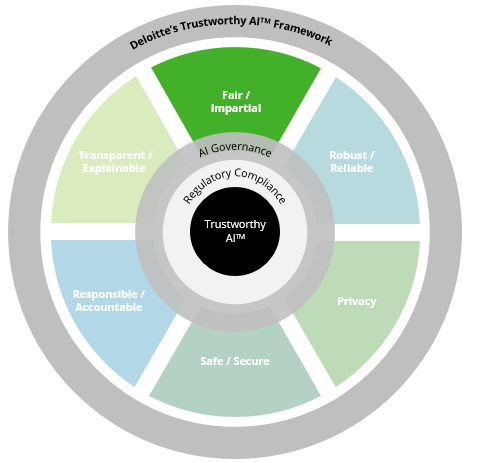


### Fair and Impartial

#### Git Repo:
https://github.com/Deloitte/aiops-package/tree/master/aiops/trustworthy

### What fairness metrics are a part of the fair and impartial module, and how should they be used? 
The emerging body of literature around fairness in machine learning and artificial intelligence in recent years has illustrated the importance of bias-conscious model design. Recent insights include the discovery that it is [nearly impossible to satisfy all fairness metrics at once](https://arxiv.org/pdf/1609.05807.pdf), that it is critical to [consider model use cases and policy along with statistical measures of equity](https://arxiv.org/pdf/1808.00023.pdf), and that [model bias can be introduced during all stages of the model development cycle](https://github.com/michelleslee/bias_in_lifecycle). We expect this field to grow rapidly in the research, tool development, and regulatory dimensions in the coming years.

The fairness package contains a selection of tools and metrics designed to help data scientists detect and evaluate bias within their models. They are meant to be used holistically, as each one explores a different facet of fairness in your models:

- Statistical Parity Difference
- Equal Opportunity Difference
- Average Odds Difference
- Disparate Impact
    - Four Fifths Rules
- Theil Index
- False Positive Rate
    - False Positive Rate Difference
    - False Positive Rate Ratio
- False Negative Rate
    - False Negative Rate Difference
    - False Negative Rate Ratio
- Balance
- Calibration

### Metric Definitions: 
_The AIF360 python package is utilized for many of the fairness metrics. Click [here](https://aif360.readthedocs.io/en/latest/modules/metrics.html), for more information on the AIF360 package._

#### Statistical Parity Difference 
Statistical parity suggests that a predictor is unbiased if the prediction yhat is independent of the protected attribute p.

Here, the same proportion of each population are classified as positive. However, this may result in different false positive and true positive rates if the true outcome y does actually vary with the protected attribute p.

Deviations from statistical parity are sometimes measured by the statistical parity difference


Technical Calculation:

- Difference in selection rates

    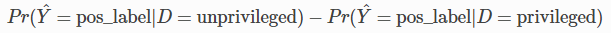

#### Equal Opportunity Difference 
Equal opportunity states that each group should get the positive outcome at equal rates, assuming that people in this group qualify for it. The equal opportunity difference is the difference in true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal benefit.

Technical Calculation:

- A relaxed version of equality of opportunity. Returns the difference in recall scores (TPR) between the unprivileged and privileged groups. A value of 0 indicates equality of opportunity. Return the ratio of true positives to positive examples in the dataset, TPR=TP/P, optionally conditioned on protected attributes.

    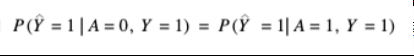

#### Average Odds Difference  
The average odds difference is the average of difference in false positive rates and true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal benefit.

Technical Calculation:
- A relaxed version of equality of odds. A value of 0 indicates equality of odds. Returns the average of the difference in FPR and TPR for the unprivileged and privileged groups:

    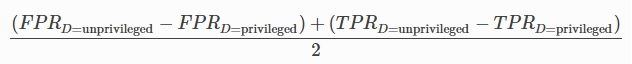
    

#### Disparate Impact 
Disparate impact is the ratio of the probability of favorable outcomes between the unprivileged and privileged groups. Disparate impact in United States labor law refers to practices in employment, housing, and other areas that adversely affect one group of people of a protected characteristic more than another, even though rules applied by employers or landlords are formally neutral. Although the protected classes vary by statute, most federal civil rights laws protect based on race, color, religion, national origin, and sex as protected traits, and some laws include disability status and other traits as well.

Technical Calculation:

   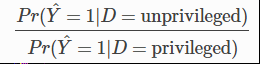

#### Four Fifths Rule
One common threshold used for measuring disparate impact is the Four-Fifths Rule, which is also known as the 80% Rule. It is a heuristic developed in the 1970s by the California Fair Employment Practice Commission and the [US Equal Employment Opportunity Commission](https://www.eeoc.gov/laws/guidance/questions-and-answers-clarify-and-provide-common-interpretation-uniform-guidelines) that states that a selection rate for any protected class which is less than four-fifths of the selection rate for the group with the highest selection rate may be an indication of disparate impact. Several alternative heuristics exist too, such as measures of protected class outcome against random sampling.

#### Theil Index 
The Theil index is a statistic used to measure economic inequality. The Theil index measures an entropic "distance" the population is away from the "ideal" egalitarian state of everyone having the same income. The numerical result is in terms of negative entropy so that a higher number indicates more order that is further away from the "ideal" of maximum disorder. Formulating the index to represent negative entropy instead of entropy allows it to be a measure of inequality rather than equality.

Technical Calculation:

   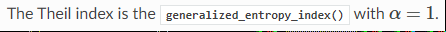

#### False Positive Rate
The false positive rate is the probability that a false alarm will be raised: that a positive result will be given when the true value is negative.

Technical Calculation:

   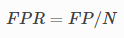
   
#### False Positive Rate Difference
Technical Calculation:

   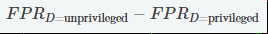


#### False Positive Rate Ratio
Technical Calculation:

   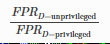

#### False Negative Rate
The false negative rate – also called the miss rate – is the probability that a true positive will be missed by the test.

Technical Calculation:

   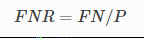

#### False Negative Rate Difference
Technical Calculation:

   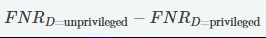

#### False Negative Rate Ratio
Technical Calculation:

   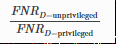

#### Calibration
The calibration test helps address whether or not the model makes accurate predictions in aggregate for members of each class.

Technical Calculation:

- A comparison of <b>actual outcome rates</b> versus <b>the predicted probabilities</b>, by decile.

#### Balance
The balance test examines whether the average score received by individuals in positive and negative instances are similar regardless of their sensitive attributes.

Technical Calculation: 

- The <b>mean prediction probability for each protected class</b>, categorized by <b>actual outcomes</b>.

### Install the TAP Software Development Kit (SDK) to use TAP Trustworthy AI (TAI) and Toolkit modules for implementing TAI methods and logging artifacts to the Tracking Server

Copy the below command into a terminal window and run it. You will need your personal access token available to enter when prompted for your username. **Note:** if you have already installed the package you will need to run a *pip uninstall tap*

# Demonstration using HMDA Example Data

## Import and Clean Data

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from tap.trustworthy import mlobject, explain, fairness, robust

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from imblearn.over_sampling import SMOTE, RandomOverSampler
from tqdm import tqdm
from minio import Minio
import boto3
import numba

#
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing


from IPython.display import Markdown, display
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [4]:
# download data to local from TAP artifact store via client
client = Minio(
        "minio-service.kubeflow.svc.cluster.local:9000",
        access_key="admin",
        secret_key="AV9%6ymFo2u^",
        secure=False)

bucket="hud-poc"
path="/unsw/UNSW_NB15_training-set.csv"
data= client.get_object(bucket_name=bucket, object_name=path)

# Load data and munge for modeling
df_train = pd.read_csv(data, index_col=0, low_memory = False)

S3Error: S3 operation failed; code: NoSuchKey, message: The specified key does not exist., resource: /hud-poc//unsw/UNSW_NB15_training-set.csv, request_id: 16B4ABD5810A2B0A, host_id: 17305c66-05ac-4be4-98de-9e37a7d01db0, bucket_name: hud-poc, object_name: /unsw/UNSW_NB15_training-set.csv

In [42]:
# take a look at the dataframe
print('Shape:', df.shape)
print('Dtypes:', df.dtypes)
df.head()

Shape: (145933, 13)
Dtypes: debt_to_income_ratio      object
loan_to_value_ratio       object
loan_amount              float64
derived_ethnicity         object
derived_race              object
derived_sex               object
applicant_age             object
preapproval              float64
loan_type                float64
loan_purpose             float64
interest_only_payment    float64
balloon_payment          float64
action_taken             float64
dtype: object


,debt_to_income_ratio,loan_to_value_ratio,loan_amount,derived_ethnicity,derived_race,derived_sex,applicant_age,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken
income,,,,,,,,,,,,,
174.0,38,90.0,335000.0,Not Hispanic or Latino,White,Joint,65-74,2.0,1.0,1.0,2.0,2.0,1.0
109.0,36,80.0,155000.0,Not Hispanic or Latino,White,Joint,65-74,2.0,1.0,1.0,2.0,2.0,1.0
79.0,30%-<36%,42.0,145000.0,Not Hispanic or Latino,White,Male,55-64,2.0,1.0,1.0,2.0,2.0,1.0
65.0,49,68.0,125000.0,Not Hispanic or Latino,White,Male,>74,2.0,1.0,1.0,2.0,2.0,1.0
95.0,20%-<30%,80.0,205000.0,Not Hispanic or Latino,White,Joint,65-74,2.0,1.0,1.0,2.0,2.0,1.0


### Null Handling

In [43]:
pd.DataFrame(df.isna().sum(axis = 0)/df.shape[0]).transpose()

,debt_to_income_ratio,loan_to_value_ratio,loan_amount,derived_ethnicity,derived_race,derived_sex,applicant_age,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken
0,0.011423,0.104233,0.0,0.0,0.0,0.0,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007


In [44]:
#Check the missing trends of debt_to_income_ratio
df[df['debt_to_income_ratio'].isnull()]['action_taken'].value_counts(normalize = True)

3.0    0.529094
1.0    0.470906
Name: action_taken, dtype: float64

In [45]:
#Check the missing trends of loan_to_value_ratio
df[df['loan_to_value_ratio'].isnull()]['action_taken'].value_counts(normalize = True)

1.0    0.600552
3.0    0.399448
Name: action_taken, dtype: float64

In [46]:
#Check the missing trends of loan_amount
df[df['loan_amount'].isnull()]['action_taken'].value_counts(normalize = True)

Series([], Name: action_taken, dtype: float64)

In [47]:
# drop nans for simplicity in this tutorial
print(df.shape)
df = df.dropna()
df.shape

(145933, 13)


(129991, 13)

In [48]:
#modify target variable
df['action_taken'] = df['action_taken'].replace([3, 1], [0, 1]).astype('int').astype('int')

### View values for each protected attribute

In [49]:
df['derived_ethnicity'].value_counts(normalize = True)

Not Hispanic or Latino     0.726173
Ethnicity Not Available    0.153418
Hispanic or Latino         0.101176
Joint                      0.019232
Name: derived_ethnicity, dtype: float64

In [50]:
df['derived_sex'].value_counts(normalize = True)

Joint                0.360417
Male                 0.322692
Female               0.224985
Sex Not Available    0.091906
Name: derived_sex, dtype: float64

In [51]:
df['derived_race'].value_counts(normalize = True)

White                                        0.684155
Race Not Available                           0.160180
Black or African American                    0.066228
Asian                                        0.060681
Joint                                        0.019794
American Indian or Alaska Native             0.004985
Native Hawaiian or Other Pacific Islander    0.002431
2 or more minority races                     0.001546
Name: derived_race, dtype: float64

In [16]:
# consider which subgroups of protected attributes have high and low application to aproval ratios. Uncomment the options below to display the full table.

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
ratios = pd.DataFrame(df.groupby(['derived_sex', 'derived_race'])['action_taken'].agg(['count','sum']).sort_values(by='count',ascending=False))
ratios['ratio'] = ratios['sum']/ratios['count']
ratios.columns = ['Count', 'Approvals', 'Approval_Ratio']
ratios.sort_values(by='Approval_Ratio')

Count  Approvals  \
derived_sex       derived_race                                                  
Sex Not Available Black or African American                     32         19   
Male              2 or more minority races                      76         49   
Sex Not Available 2 or more minority races                       3          2   
Male              American Indian or Alaska Native             335        228   
Female            American Indian or Alaska Native             196        134   
                  Black or African American                   3691       2573   
Male              Black or African American                   3099       2183   
                  Native Hawaiian or Other Pacific Islander    162        118   
Female            2 or more minority races                      82         60   
                  Race Not Available                          2269       1694   
Joint             American Indian or Alaska Native             107         80   
Sex Not Available Joint                                          4          3   
Male              Race Not Available                          3493       2626   
                  Joint                                         82         62   
Female            Asian                                       1675       1289   
Joint             Black or African American                   1787       1388   
Sex Not Available Race Not Available                         11652       9088   
                  White                                        212        166   
Joint             Native Hawaiian or Other Pacific Islander     79         62   
Sex Not Available American Indian or Alaska Native              10          8   
Female            White                                      21215      17398   
Joint             2 or more minority races                      40         33   
Female            Joint                                         46         38   
Joint             Asian                                       2633       2178   
Male              White                                      31151      25773   
                  Asian                                       3549       2957   
Joint             Race Not Available                          3408       2855   
Sex Not Available Asian                                         31         26   
Female            Native Hawaiian or Other Pacific Islander     72         61   
Joint             White                                      36356      32022   
                  Joint                                       2441       2151   
Sex Not Available Native Hawaiian or Other Pacific Islander      3          3   

                                                             Approval_Ratio  
derived_sex       derived_race                                               
Sex Not Available Black or African American                        0.593750  
Male              2 or more minority races                         0.644737  
Sex Not Available 2 or more minority races                         0.666667  
Male              American Indian or Alaska Native                 0.680597  
Female            American Indian or Alaska Native                 0.683673  
                  Black or African American                        0.697101  
Male              Black or African American                        0.704421  
                  Native Hawaiian or Other Pacific Islander        0.728395  
Female            2 or more minority races                         0.731707  
                  Race Not Available                               0.746584  
Joint             American Indian or Alaska Native                 0.747664  
Sex Not Available Joint                                            0.750000  
Male              Race Not Available                               0.751789  
                  Joint                                            0.756098  
Female            Asian                                   

In [17]:
# let's compare the White Male and the Black or African American Female
df['dual_attr'] = df['derived_race'] + ' + ' + df['derived_sex']
df = df[(df['dual_attr']=='White + Male') | (df['dual_attr']=='Black or African American + Female')]
# df = df[df['derived_ethnicity']=='Hispanic or Latino']
df.groupby('dual_attr')['action_taken'].count()

dual_attr
Black or African American + Female     3691
White + Male                          31151
Name: action_taken, dtype: int64

In [18]:
# encode the dual attribute as binary. 1 for priviledged, 0 for unpriviledged
df['dual_attr'] = np.where(df['dual_attr']=='White + Male', 1, 0)

### Attend to Data Types

In [19]:
# Condense unique debt_to_income_ratio values to fewer categories 
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].replace(['36','37','38','39','40','41','42','43','44','45','46','47','48','49'],
                                                                ['36%-40%','36%-40%','36%-40%','36%-40%','36%-40%','41%-45%','41%-45%','41%-45%','41%-45%','41%-45%','46%-59%','46%-59%','46%-59%','46%-59%'])
df['debt_to_income_ratio'].value_counts()

41%-45%     6811
36%-40%     6113
20%-<30%    5953
30%-<36%    5703
46%-59%     3888
50%-60%     2983
<20%        1943
>60%        1445
Exempt         3
Name: debt_to_income_ratio, dtype: int64

In [20]:
# function to condense unique values in 'loan_to_value_ratio'
def getLTV(var):
    if var =='Exempt':
        value = 'Exempt'
    elif float(var)>=100:
        value = '100+'
    elif float(var)<25:
        value = '<25'
    elif float(var)<40:
        value = '25-40'
    elif float(var)<50:
        value = '40-50'
    elif float(var)<60:
        value = '50-60'
    elif float(var)<70:
        value = '60-70'
    elif float(var)<80:
        value = '70-80' 
    elif float(var)<90:
        value = '80-90'     
    elif float(var)<100:
        value = '90-100'      
    return(value)

df['loan_to_value_ratio'] = df['loan_to_value_ratio'].apply(lambda x: getLTV(x))

In [21]:
df.dtypes
df.head()

,debt_to_income_ratio,loan_to_value_ratio,loan_amount,derived_ethnicity,derived_race,derived_sex,applicant_age,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken,dual_attr
income,,,,,,,,,,,,,,
79.0,30%-<36%,40-50,145000.0,Not Hispanic or Latino,White,Male,55-64,2.0,1.0,1.0,2.0,2.0,1,1
65.0,46%-59%,60-70,125000.0,Not Hispanic or Latino,White,Male,>74,2.0,1.0,1.0,2.0,2.0,1,1
114.0,30%-<36%,80-90,255000.0,Not Hispanic or Latino,White,Male,65-74,2.0,1.0,1.0,2.0,2.0,1,1
92.0,20%-<30%,60-70,185000.0,Not Hispanic or Latino,White,Male,55-64,2.0,1.0,1.0,2.0,2.0,1,1
87.0,<20%,25-40,95000.0,Ethnicity Not Available,Black or African American,Female,65-74,2.0,1.0,1.0,2.0,2.0,1,0


In [22]:
# save a list of protected attributes
prot_attrs = ['dual_attr']

In [23]:
# adjust remaining dtypes
df[df.select_dtypes(['object']).columns] = df[df.select_dtypes(['object']).columns].apply(lambda x: x.astype('category'))
df[df.select_dtypes(['float64']).columns] = df[df.select_dtypes(['float64']).columns].apply(lambda x: x.astype('int64'))
df.dtypes

debt_to_income_ratio     category
loan_to_value_ratio      category
loan_amount                 int64
derived_ethnicity        category
derived_race             category
derived_sex              category
applicant_age            category
preapproval                 int64
loan_type                   int64
loan_purpose                int64
interest_only_payment       int64
balloon_payment             int64
action_taken                int64
dual_attr                   int64
dtype: object

### Model Prep: Dummies, train test split, oversampling

In [24]:
# get dummies of categorical data
df_dum = pd.get_dummies(df, drop_first=True)
X = df_dum.drop('action_taken', axis=1)
y = df_dum['action_taken']

In [25]:
y.head()

income
79.0     1
65.0     1
114.0    1
92.0     1
87.0     1
Name: action_taken, dtype: int64

In [26]:
X.head()

,loan_amount,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,dual_attr,debt_to_income_ratio_30%-<36%,debt_to_income_ratio_36%-40%,debt_to_income_ratio_41%-45%,...,derived_ethnicity_Joint,derived_ethnicity_Not Hispanic or Latino,derived_race_White,derived_sex_Male,applicant_age_35-44,applicant_age_45-54,applicant_age_55-64,applicant_age_65-74,applicant_age_<25,applicant_age_>74
income,,,,,,,,,,,,,,,,,,,,,
79.0,145000,2,1,1,2,2,1,1,0,0,...,0,1,1,1,0,0,1,0,0,0
65.0,125000,2,1,1,2,2,1,0,0,0,...,0,1,1,1,0,0,0,0,0,1
114.0,255000,2,1,1,2,2,1,1,0,0,...,0,1,1,1,0,0,0,1,0,0
92.0,185000,2,1,1,2,2,1,0,0,0,...,0,1,1,1,0,0,1,0,0,0
87.0,95000,2,1,1,2,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [27]:
# split data and check target variable balance
train, test = train_test_split(df_dum, test_size=0.4, random_state=1, stratify=df_dum['dual_attr'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=X['dual_attr'])
y_train.value_counts(normalize=True)

1    0.812246
0    0.187754
Name: action_taken, dtype: float64

In [28]:
# # use SMOTE oversampling method for imbalanced dataset
over = SMOTE(random_state=123)
# over = RandomOverSampler(random_state=123)
X_over, y_over = over.fit_resample(X_train, y_train)
y_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: action_taken, dtype: float64

### Baseline model

In [52]:
# Random Forest - Set random_state for reproducibility
base_model = RandomForestClassifier(random_state=123)
base_model.fit(X_over, y_over)
y_pred_train = base_model.predict(X_over)
y_pred = base_model.predict(X_test)
y_proba = base_model.predict_proba(X_test)
accuracy_score(y_test, y_pred)

0.7801535481093492

## Bias Detection

### Record fairness and classification metrics

In [53]:
# prepare column names and label objects for fairness class
x_col = list(X_test.columns)
y_col = y_test._name

In [54]:
# Define fairness metrics
base_fair = fairness.Fairness(X=np.array(X_test),
                       y=np.array(y_test),
                       feature_names=x_col,
                       label_name=y_col,
                       prediction=y_pred)

In [55]:
# Call fairness classification metrics
base_fair_metrics = base_fair.get_classification_fairness_metrics(protected_attributes=prot_attrs,
                                                                      privileged_classes = [lambda x: x==1],
                                                                      privileged_groups = [{'dual_attr': 1}],
                                                                      unprivileged_groups = [{'dual_attr': 0}],
                                                                      prob_pred = y_proba)
base_fair_df = pd.DataFrame(base_fair_metrics, index=['Baseline'])

In [56]:
# use the robust package to get binary classification metrics
base_robust = robust.Robust(X=np.array(X_test),
                           y=np.array(y_test),
                           feature_names=x_col,
                           label_name=y_col,
                           prediction=y_pred)
base_robust_metrics = base_robust.get_binary_classification_robust_metrics(prob_pred=y_proba[:,1])
base_robust_df = pd.DataFrame(base_robust_metrics, index=['Baseline'])

### Display Four Fifths Plot 

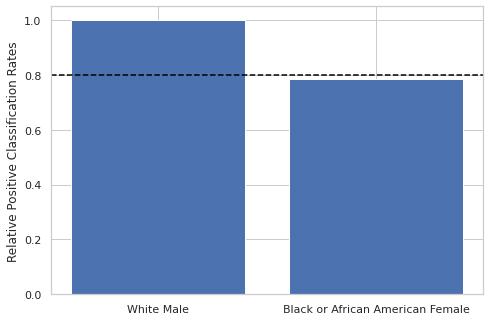

In [57]:
# Calculate Four Fifths Rule Test
X_test['prediction'] = y_pred
male = X_test[X_test['dual_attr']==1]
female = X_test[X_test['dual_attr']==0]
maleRate = sum(male['prediction'])/len(male)
femaleRate = sum(female['prediction'])/len(female)
ratio = femaleRate/maleRate
X_test = X_test.drop('prediction', axis=1)

# Disparate impact calculation 
disparate_impact = maleRate/femaleRate 

# Plot Four Fifths Rule Test
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['White Male', 'Black or African American Female']
rates = [1, ratio]
ax.bar(classes,rates)
ax.set_ylabel('Relative Positive Classification Rates')
ax.axhline(.8, ls='--', c='black')
plt.show()

In [58]:
base_fair.four_fifths_rule(protected_attributes=prot_attrs)

{'dual_attr':    dual_attr  Average_Outcome  Comparative_Rate
 0          0         0.633469          0.783178
 1          1         0.808844          1.000000}

<Figure size 720x576 with 0 Axes>

## BIAS MITIGATION!  
We've identified bias in our model, so what options do we have to reduce it?

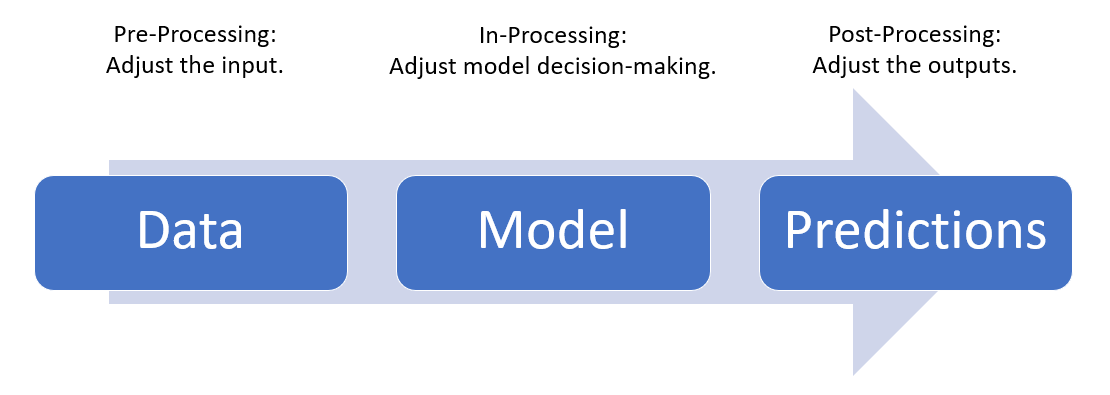

### How do you choose which method to use?
Bias can be introduced or amplified at any step of a data science pipeline. So your very first consideration may be to choose techniques that specifically target the step in question. 

You might decide on specfic mitigation methods for specific fairness results.

Or perhaps your decision process will be affected by constraints in your pipeline. Possible examples could include: You have a model fine tuned for your specific use case that will be unrealistic to change, then you might elect only preprocessing methods to aid your fairness efforts. Or, because the data you run your models on is difficult to access or modify you decide to mitigate bias further down the line.  


## Preprocessing

In [59]:
# use preprocessing methods on both training and testing data
preproc_train = fairness.Preprocessing(X=np.array(X_over), 
                           y=np.array(y_over), 
                           feature_names=x_col, 
                           label_name=y_col, 
                           protected_attributes=prot_attrs, 
                           privileged_classes = [lambda x: x==1],
                           privileged_groups = [{'dual_attr': 1}],
                           unprivileged_groups = [{'dual_attr': 0}], 
                           favorable_target=["1"])

### Disparate Impact Remover:

Edits feature values to increase group fairness while preserving rank-ordering within groups.

In [60]:
# Use the disparate impact remover from the preprocessing class
repair_level = 0.51
train_disimp_rem = preproc_train.disparate_impact_remover(repair_level)

# split resulting dataframe into features and targets
X_train_disimp = train_disimp_rem.drop('action_taken', axis=1)
y_train_disimp = train_disimp_rem['action_taken']

In [61]:
# Random Forest - Prediction after disparate impact remover
disimp_model = RandomForestClassifier(random_state=123)
disimp_model.fit(X_train_disimp, y_train_disimp)
disimp_pred = disimp_model.predict(X_test)
disimp_proba = disimp_model.predict_proba(X_test)
accuracy_score(y_test, disimp_pred)

0.7885484681064792

#### Record fairness and classification metrics

In [62]:
# Define and view fairness metrics after disparate impact remover
disimp_fair = fairness.Fairness(X=np.array(X_test),
                       y=np.array(y_test),
                       feature_names=x_col,
                       label_name=y_col,
                       prediction=disimp_pred)

# Call fairness classification metrics
disimp_fair_metrics = disimp_fair.get_classification_fairness_metrics(protected_attributes=prot_attrs,
                                                                      privileged_classes = [lambda x: x==1],
                                                                      privileged_groups = [{'dual_attr': 1}],
                                                                      unprivileged_groups = [{'dual_attr': 0}],
                                                                      prob_pred = disimp_proba)
disimp_fair_df = pd.DataFrame(disimp_fair_metrics, index=['Disparate Impact Remover'])

In [63]:
# View robust performance metrics after disparate impact remover
disimp_robust = robust.Robust(X=np.array(X_test),
                             y=np.array(y_test),
                             feature_names=x_col,
                             label_name=y_col,
                             prediction=disimp_pred)
disimp_robust_metrics = disimp_robust.get_binary_classification_robust_metrics(prob_pred=disimp_proba[:,1])
disimp_robust_df = pd.DataFrame(disimp_robust_metrics, index=['Disparate Impact Remover'])

#### Display the Four Fifths Plot

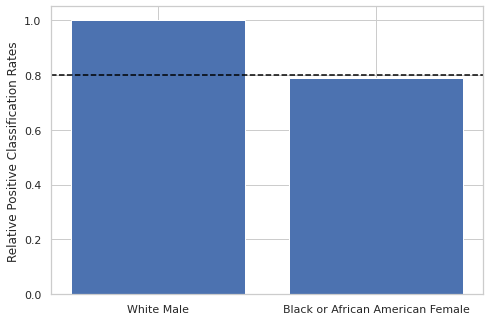

In [64]:
# Calculate Four Fifths Rule Test after disparate impact remover
X_test['disimp_prediction'] = disimp_pred
male = X_test[X_test['dual_attr']==1]
female = X_test[X_test['dual_attr']==0]
maleRate = sum(male['disimp_prediction'])/len(male)
femaleRate = sum(female['disimp_prediction'])/len(female)
ratio = femaleRate/maleRate
X_test = X_test.drop('disimp_prediction', axis=1)

# Disparate impact calculation 
disparate_impact = maleRate/femaleRate 

# Plot Four Fifths Rule Test
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['White Male', 'Black or African American Female']
rates = [1, ratio]
ax.bar(classes,rates)
ax.set_ylabel('Relative Positive Classification Rates')
ax.axhline(.8, ls='--', c='black')
plt.show()

In [65]:
disimp_fair.four_fifths_rule(protected_attributes=prot_attrs)

{'dual_attr':    dual_attr  Average_Outcome  Comparative_Rate
 0          0         0.652439          0.788406
 1          1         0.827542          1.000000}

<Figure size 720x576 with 0 Axes>

## Compare Fairness and Classification Metrics Across Each Method

In [66]:
fairness_df = base_fair_df.append(disimp_fair_df)
robust_df = base_robust_df.append(disimp_robust_df)
metrics_df = pd.concat([fairness_df, robust_df], axis=1)
metrics_df.fairness_disparate_impact.round(2)

Baseline                    0.78
Disparate Impact Remover    0.79
Name: fairness_disparate_impact, dtype: float64


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.


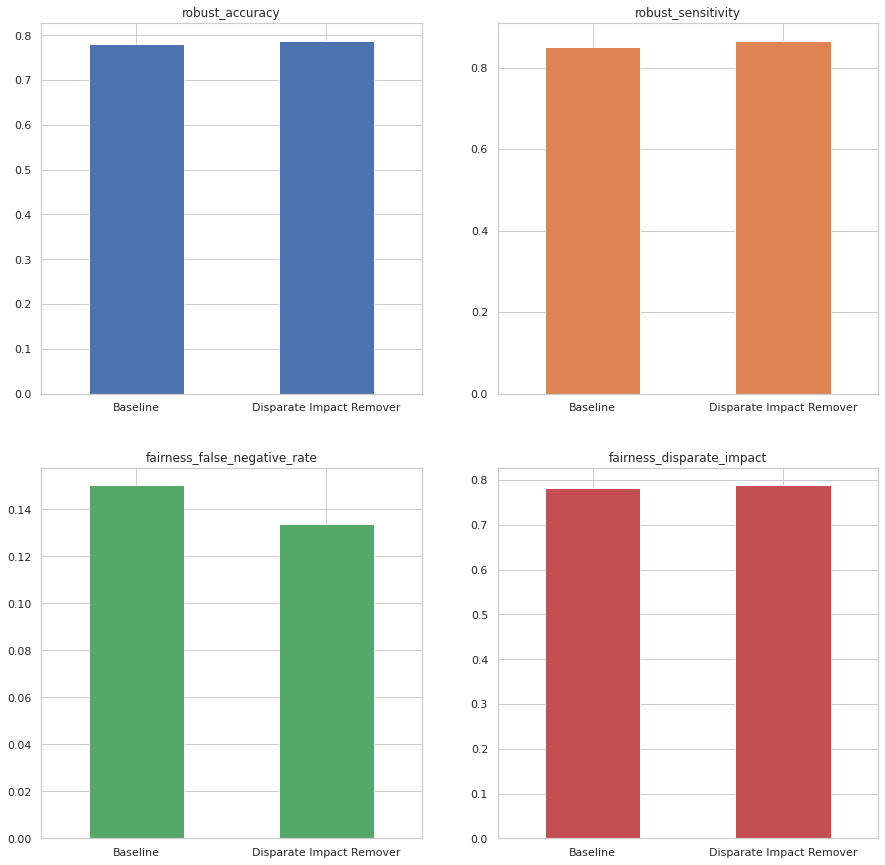

In [67]:
# identify which metrics you care about and plot
metrics = ['robust_accuracy', 'robust_sensitivity', 'fairness_false_negative_rate', 'fairness_disparate_impact']

metrics_df[metrics].plot(kind='bar', subplots=True, sharex=False, rot=0, figsize=(15, 15), layout=(2,2), legend=False)
plt.show()

# Summary

In the TAP fairness package you not only acquire the metrics to identify and quantify bias in your pipeline, but you also get the tools you need to reduce that bias. 

Approaching bias mitigation in this way gives your team the flexibility to optimize for the aspects of fairness playing a crucial role in your project's successful adoption and deployment.

And on top of that, when fairness is used in conjunction with other Trustworthy AI pillars like the robust package, you can monitor the impact of these fairness adjustments have on other important classification metrics.

## What's Next?

In this tutorial notebook we have seen multiple Pre-processing and Post-processing techniques in action. We will continue to incorporate additional fairness metrics as they become defined and available in this rapidly growing topic.

Pre-processing and Post-processing methods will continue to be added as they pass testing, and in the near future we will have the first In-processing capabilities implemented as well. 